**Assignment Week 7**

Due: 3/11/2024

Shimon Greengart

This is my data. I had to separate the data for the regular neural network from the CNN, since they wanted different shapes.


In [ ]:
import numpy as np
from tensorflow import keras as kr
from sklearn import model_selection, metrics
import matplotlib.pyplot as plt

(X, Y), (X_test, Y_test) = kr.datasets.mnist.load_data()

# train-validation-test split
X_train, X_val, Y_train, Y_val = model_selection.train_test_split(X, Y, test_size=0.2, shuffle=True, stratify=Y)
# I pass it in as a 2D array
X_train = X_train.reshape((X_train.shape[0], 28, 28)).astype('float32')
X_test = X_test.reshape((X_test.shape[0], 28, 28)).astype('float32')
X_val = X_val.reshape((X_val.shape[0], 28, 28)).astype('float32')

nn_X_train = X_train.reshape((X_train.shape[0], 784)).astype('float32')
nn_X_test = X_test.reshape((X_test.shape[0], 784)).astype('float32')
nn_X_val = X_val.reshape((X_val.shape[0], 784)).astype('float32')

Y_train_hot = kr.utils.to_categorical(Y_train)
Y_val_hot = kr.utils.to_categorical(Y_val)
Y_test_hot = kr.utils.to_categorical(Y_test)

11490434/11490434 [==============================] - 0s 0us/step


Here I train my neural network from last time. I didn't change it, so that we could have a proper comparison.

In [ ]:
NN_NUM_FEATURES = len(nn_X_train[0])
NN_NUM_CLASSES = 10
NN_HIDDEN_SIZE = 64
NN_LEARNING_RATE = 0.00025
NN_NUM_EPOCHS = 50

nn_model = kr.models.Sequential()
nn_model.add(kr.Input(shape=(NN_NUM_FEATURES,)))
nn_model.add(kr.layers.Dense(NN_HIDDEN_SIZE, activation='relu'))
nn_model.add(kr.layers.Dense(NN_NUM_CLASSES, activation='softmax'))

nn_model.compile(optimizer=kr.optimizers.Adam(learning_rate=NN_LEARNING_RATE), loss='categorical_crossentropy',
                 metrics=[kr.metrics.CategoricalAccuracy(), kr.metrics.Precision(), kr.metrics.Recall()])
nn_model.fit(nn_X_train, Y_train_hot, epochs=NN_NUM_EPOCHS, validation_data=(nn_X_val, Y_val_hot))

Epoch 1/50
1500/1500 [==============================] - 5s 3ms/step - loss: 9.2115 - categorical_accuracy: 0.7949 - precision: 0.7951 - recall: 0.7948 - val_loss: 2.6839 - val_categorical_accuracy: 0.8668 - val_precision: 0.8672 - val_recall: 0.8667
Epoch 2/50
1500/1500 [==============================] - 4s 3ms/step - loss: 1.6896 - categorical_accuracy: 0.8728 - precision: 0.8778 - recall: 0.8712 - val_loss: 1.2346 - val_categorical_accuracy: 0.8561 - val_precision: 0.8730 - val_recall: 0.8493
Epoch 3/50
1500/1500 [==============================] - 5s 3ms/step - loss: 0.7927 - categorical_accuracy: 0.8716 - precision: 0.8974 - recall: 0.8528 - val_loss: 0.8073 - val_categorical_accuracy: 0.8617 - val_precision: 0.8952 - val_recall: 0.8337
Epoch 4/50
1500/1500 [==============================] - 4s 3ms/step - loss: 0.5192 - categorical_accuracy: 0.8933 - precision: 0.9234 - recall: 0.8687 - val_loss: 0.6213 - val_categorical_accuracy: 0.8858 - val_precision: 0.9187 - val_recall: 0.8602


This is my CNN. I found that the learning rate and number of epochs from last time were still efficient. I found that 25 filters of size 10 produced good results (I can't say why, it was trial-and-error).

The shape of my neural network started with a convolutional layer, with the characteristics I just explained. It is followed by a max pool of size 2, I tried adding a second convolutional layer and max pool, but I didn't find it to improve anything. After the convolutional layer, I flatten the input into 1D to input it to the dense layers. I found that two dense layers worked best, one with 160 nodes and the next with 30 nodes, that consistently got above a validation accuracy of 0.983.

I use a callback to end training once I'm done, but I set it not to trigger too early, lest it stop me before I was actually done training.

In [ ]:
# This is fundamental stuff
SIZE_LEN = len(X_train[0])
NUM_CLASSES = 10
LEARNING_RATE = 0.00025
NUM_EPOCHS = 50

FILTER_NUM = 25
FILTER_SIZE = 10
FILTER_STRIDE = 1

POOL_SIZE = 2

DENSE_SIZE = 160
SECOND_DENSE_SIZE = 30

# Let's start with a single convolutional layer with a max pool followed by a single dense layer
model = kr.models.Sequential()
model.add(kr.Input(shape=(SIZE_LEN, SIZE_LEN, 1)))

model.add(kr.layers.Conv2D(filters=FILTER_NUM, kernel_size=FILTER_SIZE, strides=FILTER_STRIDE, activation='relu'))
model.add(kr.layers.MaxPooling2D(pool_size=POOL_SIZE))
model.add(kr.layers.Flatten())

model.add(kr.layers.Dense(DENSE_SIZE, activation='relu'))
model.add(kr.layers.Dense(SECOND_DENSE_SIZE, activation='relu'))
model.add(kr.layers.Dense(NUM_CLASSES, activation='softmax'))

model.summary()

# kr.utils.plot_model(model)

model.compile(optimizer=kr.optimizers.Adam(learning_rate=LEARNING_RATE), loss='categorical_crossentropy',
              metrics=[kr.metrics.CategoricalAccuracy(), kr.metrics.Recall(), kr.metrics.Precision()])

history = model.fit(X_train, Y_train_hot, epochs=NUM_EPOCHS, validation_data=(X_val, Y_val_hot),
                    callbacks=[kr.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=2, start_from_epoch=9)])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 19, 19, 25)        2525      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 9, 9, 25)          0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 2025)              0         
                                                                 
 dense_11 (Dense)            (None, 160)               324160    
                                                                 
 dense_12 (Dense)            (None, 30)                4830      
                                                                 
 dense_13 (Dense)            (None, 10)                310       
                                                      

Here we plot the loss curve from the CNN.

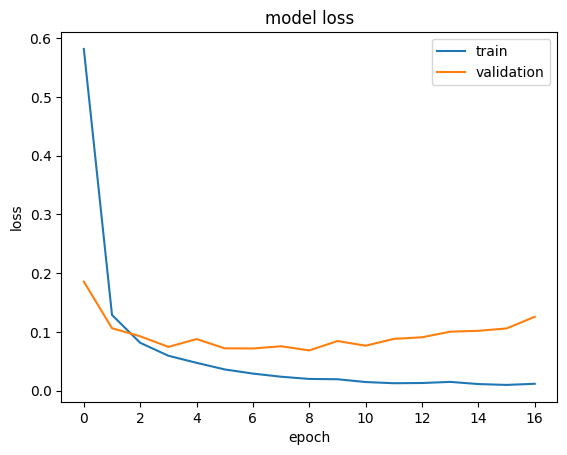

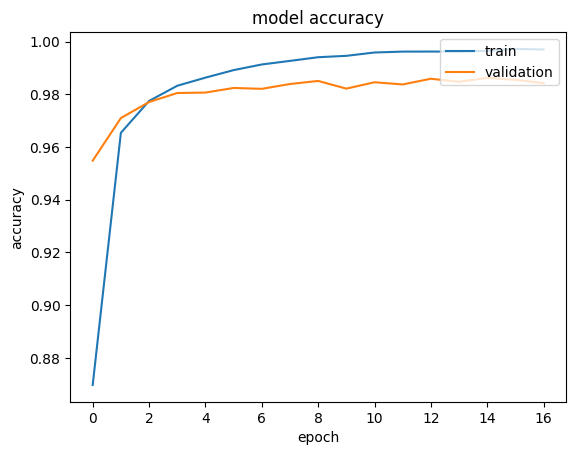

In [ ]:
# plot the loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

Below, I evaluate both the neural network and CNN on test data. As you can see, my CNN is better in every way I could measure: accuracy, precision, and recall, both in general and for every inidividual letter. When it does confuse digits, it is mostly evenly spread. However, when 2 is confused, it is almost always confused to be a 5. 3 is sometimes confused as a 2 or 5. 4 is sometimes confused with 9. 5 is sometimes confused with 3, the greatest number of one thing confused as another. 7 is sometimes confused with 1 or 9. 8 has the worst recall, being confused with 0 or 9. And 9 is sometimes confused with 4. 9 has the worst precision, since 4, 7, and 8 are all confused with it.

Results for neural network:
313/313 [==============================] - 2s 6ms/step - loss: 0.3678 - categorical_accuracy: 0.9601 - precision: 0.9611 - recall: 0.9593


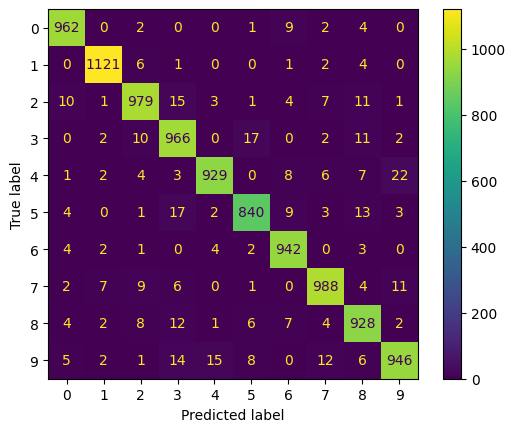

0: Precision is 0.970 and recall is 0.982
1: Precision is 0.984 and recall is 0.988
2: Precision is 0.959 and recall is 0.949
3: Precision is 0.934 and recall is 0.956
4: Precision is 0.974 and recall is 0.946
5: Precision is 0.959 and recall is 0.942
6: Precision is 0.961 and recall is 0.983
7: Precision is 0.963 and recall is 0.961
8: Precision is 0.936 and recall is 0.953
9: Precision is 0.958 and recall is 0.938


In [4]:
# evaluate the neural network on test data
print("Results for neural network:")
nn_model.evaluate(nn_X_test, Y_test_hot)

test_prediction = [np.argmax(point) for point in nn_model.predict(nn_X_test, verbose=0)]

metrics.ConfusionMatrixDisplay.from_predictions(Y_test, test_prediction)
plt.show()

nn_confusion_matrix = metrics.confusion_matrix(Y_test, test_prediction)

for num in range(NN_NUM_CLASSES):
        precision = nn_confusion_matrix[num, num] / sum(nn_confusion_matrix[:, num])
        recall = nn_confusion_matrix[num, num] / sum(nn_confusion_matrix[num, :])
        print("%d:" % num, "Precision is %.3f" % precision, "and recall is %.3f" % recall)

Results for CNN:
313/313 [==============================] - 2s 5ms/step - loss: 0.0840 - categorical_accuracy: 0.9850 - recall_3: 0.9847 - precision_3: 0.9857


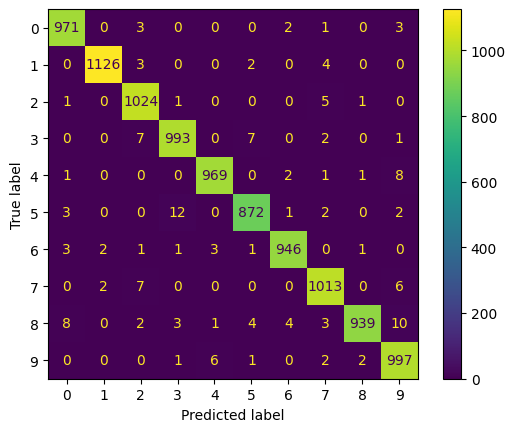

0: Precision is 0.984 and recall is 0.991
1: Precision is 0.996 and recall is 0.992
2: Precision is 0.978 and recall is 0.992
3: Precision is 0.982 and recall is 0.983
4: Precision is 0.990 and recall is 0.987
5: Precision is 0.983 and recall is 0.978
6: Precision is 0.991 and recall is 0.987
7: Precision is 0.981 and recall is 0.985
8: Precision is 0.995 and recall is 0.964
9: Precision is 0.971 and recall is 0.988


In [ ]:
# evaluating on test data
print("Results for CNN:")
model.evaluate(X_test, Y_test_hot)

test_prediction = [np.argmax(point) for point in model.predict(X_test, verbose=0)]

metrics.ConfusionMatrixDisplay.from_predictions(Y_test, test_prediction)
plt.show()

confusion_matrix = metrics.confusion_matrix(Y_test, test_prediction)
for num in range(NUM_CLASSES):
        precision = confusion_matrix[num, num] / sum(confusion_matrix[:, num])
        recall = confusion_matrix[num, num] / sum(confusion_matrix[num, :])
        print("%d:" % num, "Precision is %.3f" % precision, "and recall is %.3f" % recall)